Load & Clean & Export Data

In [68]:
import pandas as pd

# Load the dataset (Ensure correct file path)
file_path = "fastFood2022.xlsx"
df = pd.read_excel(file_path)

# Define the selected restaurants
selected_restaurants = [
    "Arby's", "Buffalo Wild Wings", "Burger King", "Chick Fil A",
    "Dairy Queen", "Firehouse Subs", "In-N-Out",
    "Jack in the Box", "KFC", "McDonald's", "Panera Bread",
    "Pizza Hut", "Popeyes", "Raising Cane's Chicken Fingers",
    "Sonic", "Steak 'N Shake", "Taco Bell", "Wendy's", "Whataburger"
]

# Define columns to remove
columns_to_remove = [
    "matched_2021", "new_item_2022", "menu_item_id", "potassium", "notes",
    "calories_text", "total_fat_text", "saturated_fat_text", "trans_fat_text",
    "cholesterol_text", "sodium_text", "carbohydrates_text", "dietary_fiber_text",
    "sugar_text", "protein_text", "serving_size", "serving_size_text",
    "serving_size_unit", "serving_size_household"
]

# Define food categories to remove
categories_to_remove = ["Toppings & Ingredients", "Beverages", "Fried Potatoes", "Baked Goods", "Desserts","Appetizers & Sides"]

# Step 1: Filter for selected restaurants
filtered_df = df[df["restaurant"].isin(selected_restaurants)]

# Step 2: Remove unwanted food categories
filtered_df = filtered_df[~filtered_df["food_category"].isin(categories_to_remove)]

# Step 3: Drop unnecessary columns
filtered_df = filtered_df.drop(columns=[col for col in columns_to_remove if col in filtered_df.columns], errors="ignore")

# Step 4: Remove rows with missing values
filtered_df = filtered_df.dropna().reset_index(drop=True)

# Step 5: Save the cleaned and filtered data
output_file = "cleaned-fastFood2022.xlsx"
filtered_df.to_excel(output_file, index=False)

print(f"Filtered and cleaned data saved as: {output_file}")


Filtered and cleaned data saved as: cleaned-fastFood2022.xlsx


Feature Engineering

In [69]:
import pandas as pd

# Load the cleaned data
df = pd.read_excel("cleaned-fastFood2022.xlsx")

# Daily recommended values for reference
daily_values = {
    'calories': 2000,
    'total_fat': 78,
    'saturated_fat': 20,
    'trans_fat': 2,
    'cholesterol': 300,
    'sodium': 2300,
    'carbohydrates': 275,
    'dietary_fiber': 28,
    'sugar': 50,
    'protein': 50
}

# Per-meal targets (1/3 of daily values)
meal_values = {k: v / 3 for k, v in daily_values.items()}

def compute_health_score(row):
    bad_keys = ['calories', 'total_fat', 'saturated_fat', 'trans_fat', 'cholesterol', 'sodium', 'sugar']
    good_keys = ['dietary_fiber', 'protein']
    
    # Normalize and cap
    bad_score = sum(min(row[k] / meal_values[k], 1.5) for k in bad_keys)
    good_score = sum(min(row[k] / meal_values[k], 1.0) for k in good_keys)

    # Weighted balance
    normalized_bad = bad_score / len(bad_keys)
    normalized_good = good_score / len(good_keys)

    # Compute score and scale from 1 to 10
    raw_score = (1.5 - normalized_bad) * 6 + normalized_good * 4  # max is 10
    return max(1, min(10, round(raw_score, 1)))

def compute_reasoning(row):
    high = []
    low = []

    for k in ['calories', 'total_fat', 'saturated_fat', 'trans_fat', 'cholesterol', 'sodium', 'sugar']:
        if row[k] > meal_values[k]:
            high.append(k.replace('_', ' '))

    for k in ['dietary_fiber', 'protein']:
        if row[k] < meal_values[k] * 0.7:
            low.append(k.replace('_', ' '))

    parts = []
    if high:
        parts.append(f"High: {', '.join(high)}")
    if low:
        parts.append(f"Low: {', '.join(low)}")

    return " | ".join(parts) if parts else "Balanced"


# Apply health score & reasoning
df['health_score'] = df.apply(compute_health_score, axis=1)
df['reasoning'] = df.apply(compute_reasoning, axis=1)

# Save the enhanced dataset
df.to_excel("enhanced-fastFood2022.xlsx", index=False)

print("Enhanced data with health score saved as: enhanced-fastFood2022.xlsx")


Enhanced data with health score saved as: enhanced-fastFood2022.xlsx


Train the Model

In [70]:
import pandas as pd

df = pd.read_excel("enhanced-fastFood2022.xlsx")

features = [
    'calories', 'total_fat', 'saturated_fat', 'trans_fat',
    'cholesterol', 'sodium', 'carbohydrates', 'dietary_fiber',
    'sugar', 'protein'
]
target = 'health_score'

X = df[features]
y = df[target]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


MSE: 0.14
R²: 0.95


Display Graphs

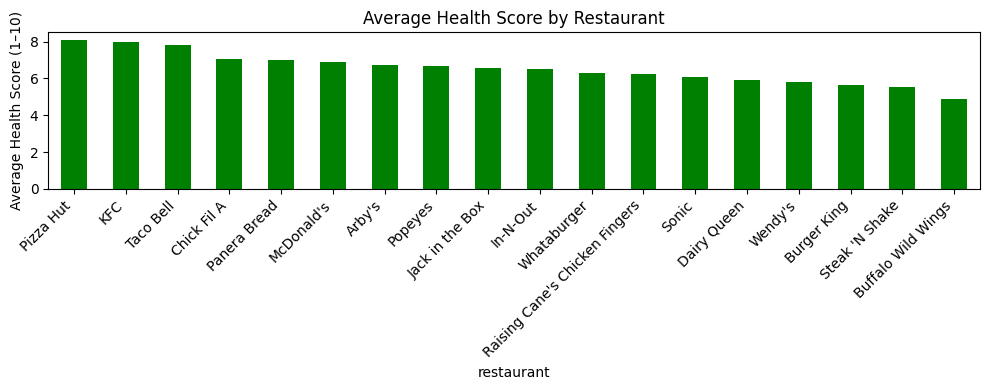

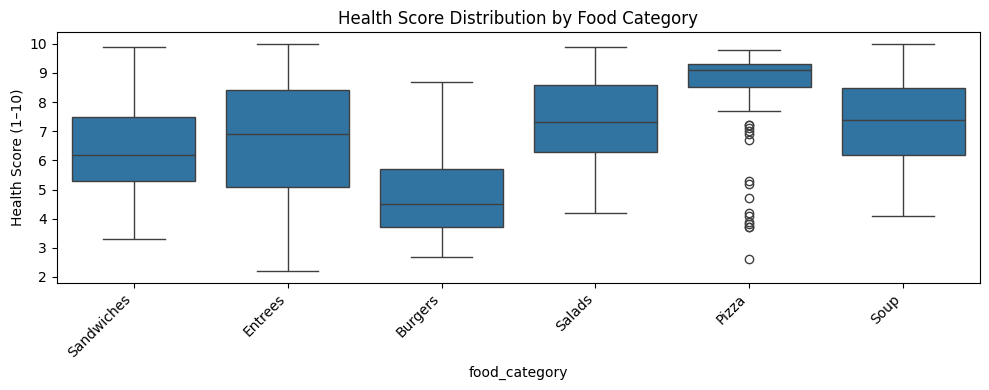

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the enhanced dataset
df = pd.read_excel("enhanced-fastFood2022.xlsx")

# --- Plot 1: Average Health Score by Restaurant ---

# Calculate average health score per restaurant
avg_scores = df.groupby('restaurant')['health_score'].mean().sort_values(ascending=False)

# Create a bar plot of average scores
plt.figure(figsize=(10, 4))
avg_scores.plot(kind='bar', color='green')
plt.title("Average Health Score by Restaurant")
plt.ylabel("Average Health Score (1–10)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- Plot 2: Health Score Distribution by Food Category ---

# Create a box plot of health scores grouped by food category
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='food_category', y='health_score')
plt.title("Health Score Distribution by Food Category")
plt.ylabel("Health Score (1–10)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Define Food Recommendations

In [72]:
import pandas as pd

# Load enhanced dataset
df = pd.read_excel("enhanced-fastFood2022.xlsx")

def recommend_food(hunger, health, restaurant="any", count=5):
    # Calorie ranges based on hunger level
    hunger_map = {
        "low": (0, 400),
        "medium": (401, 999),
        "high": (1000, 2000)
    }

    # Health score ranges
    health_map = {
        "high": (8, 10),
        "medium": (5, 7.9),
        "low": (1, 4.9)
    }

    # Apply filters
    low_cal, high_cal = hunger_map[hunger]
    low_score, high_score = health_map[health]

    filtered = df[
        (df['calories'] >= low_cal) & (df['calories'] <= high_cal) &
        (df['health_score'] >= low_score) & (df['health_score'] <= high_score)
    ]

    if restaurant.lower() != "any":
        filtered = filtered[filtered['restaurant'].str.lower() == restaurant.lower()]

    # Select and format top results
    if not filtered.empty:
        results = filtered.sample(min(count, len(filtered)))
        for _, row in results.iterrows():
            print(f"{row['restaurant']} | {row['item_name']} | {row['calories']} | Score: {row['health_score']} | {row['reasoning']}")
    else:
        print("No matching items found. Try different criteria.")

# Example usage:
recommend_food(hunger="medium", health="high", restaurant="any")



Panera Bread | BBQ Chicken Salad - Whole | 490 | Score: 8.5 | High: sodium
Panera Bread | Thai Chicken Soup - Bread Bowl | 820 | Score: 8.3 | High: calories, saturated fat, sodium
Panera Bread | Ten Vegetable Soup - Bread Bowl | 730 | Score: 9.7 | High: calories, sodium
Taco Bell | Nachos BellGrande - Chicken | 710 | Score: 8.6 | High: calories, total fat, sodium
Steak 'N Shake | Spicy Chicken Sandwich | 480 | Score: 8.1 | High: sodium | Low: dietary fiber
